torch.Size([1, 3, 256, 256, 2])


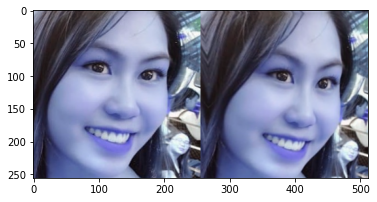

In [8]:
from torch import nn
import torch.nn.functional as F
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np


def make_coordinate_grid(spatial_size, type):
    """
    Create a meshgrid [-1,1] x [-1,1] of given spatial_size.
    """
    h, w = spatial_size
    x = torch.arange(w).type(type)
    y = torch.arange(h).type(type)

    x = (2 * (x / (w - 1)) - 1)
    y = (2 * (y / (h - 1)) - 1)

    yy = y.view(-1, 1).repeat(1, w)
    xx = x.view(1, -1).repeat(h, 1)

    meshed = torch.cat([xx.unsqueeze_(2), yy.unsqueeze_(2)], 2)

    return meshed

class TPS:
    '''
    TPS transformation, mode 'kp' for Eq(2) in the paper, mode 'random' for equivariance loss.
    '''
    def __init__(self, mode, bs, **kwargs):
        self.bs = bs
        self.mode = mode
        if mode == 'random':
            noise = torch.normal(mean=0, std=kwargs['sigma_affine'] * torch.ones([bs, 2, 3]))
            self.theta = noise + torch.eye(2, 3).view(1, 2, 3)
            self.control_points = make_coordinate_grid((kwargs['points_tps'], kwargs['points_tps']), type=noise.type())
            self.control_points = self.control_points.unsqueeze(0)
            self.control_params = torch.normal(mean=0, 
                        std=kwargs['sigma_tps'] * torch.ones([bs, 1, kwargs['points_tps'] ** 2]))
        elif mode == 'kp':
            kp_1 = kwargs["kp_1"]
            kp_2 = kwargs["kp_2"]
            device = kp_1.device
            kp_type = kp_1.type()
            self.gs = kp_1.shape[1]
            n = kp_1.shape[2]
            K = torch.norm(kp_1[:,:,:, None]-kp_1[:,:, None, :], dim=4, p=2)
            K = K**2
            K = K * torch.log(K+1e-9)
#             print(f'K:{K}')
            
            one1 = torch.ones(self.bs, kp_1.shape[1], kp_1.shape[2], 1).to(device).type(kp_type)
            kp_1p = torch.cat([kp_1,one1], 3)
            
            zero = torch.zeros(self.bs, kp_1.shape[1], 3, 3).to(device).type(kp_type)
            P = torch.cat([kp_1p, zero],2)
            L = torch.cat([K,kp_1p.permute(0,1,3,2)],2)
            L = torch.cat([L,P],3)
        
            zero = torch.zeros(self.bs, kp_1.shape[1], 3, 2).to(device).type(kp_type)
            Y = torch.cat([kp_2, zero], 2)
            one = torch.eye(L.shape[2]).expand(L.shape).to(device).type(kp_type)*0.01
            L = L + one

            param = torch.matmul(torch.inverse(L),Y)
            self.theta = param[:,:,n:,:].permute(0,1,3,2)
#             print(f'Theta :{self.theta}')

            self.control_points = kp_1
            self.control_params = param[:,:,:n,:]
        else:
            raise Exception("Error TPS mode")

    def transform_frame(self, frame):
        grid = make_coordinate_grid(frame.shape[2:], type=frame.type()).unsqueeze(0).to(frame.device)
        grid = grid.view(1, frame.shape[2] * frame.shape[3], 2)
        shape = [self.bs, frame.shape[2], frame.shape[3], 2]
        if self.mode == 'kp':
            shape.insert(1, self.gs)
        grid = self.warp_coordinates(grid).view(*shape)
        return grid

    def warp_coordinates(self, coordinates):
        theta = self.theta.type(coordinates.type()).to(coordinates.device)
        control_points = self.control_points.type(coordinates.type()).to(coordinates.device)
        control_params = self.control_params.type(coordinates.type()).to(coordinates.device)

        if self.mode == 'kp':
            transformed = torch.matmul(theta[:, :, :, :2], coordinates.permute(0, 2, 1)) + theta[:, :, :, 2:]

            distances = coordinates.view(coordinates.shape[0], 1, 1, -1, 2) - control_points.view(self.bs, control_points.shape[1], -1, 1, 2)

            distances = distances ** 2
            result = distances.sum(-1)
            result = result * torch.log(result + 1e-9)
            result = torch.matmul(result.permute(0, 1, 3, 2), control_params)
            transformed = transformed.permute(0, 1, 3, 2) + result

        elif self.mode == 'random':
            theta = theta.unsqueeze(1)
            transformed = torch.matmul(theta[:, :, :, :2], coordinates.unsqueeze(-1)) + theta[:, :, :, 2:]
            transformed = transformed.squeeze(-1)
            ances = coordinates.view(coordinates.shape[0], -1, 1, 2) - control_points.view(1, 1, -1, 2)
            distances = ances ** 2

            result = distances.sum(-1)
            result = result * torch.log(result + 1e-9)
            result = result * control_params
            result = result.sum(dim=2).view(self.bs, coordinates.shape[1], 1)
            transformed = transformed + result
        else:
            raise Exception("Error TPS mode")

        return transformed

def create_sparse_thin_plate_spline_motion(source_image, kp_driving, kp_src):
    # Identity grid
    bs, _, h, w = source_image.shape
    identity_grid = make_coordinate_grid((h, w), type=kp_src['value'].type())
    identity_grid = identity_grid.view(1, 1, h, w, 2)
    identity_grid = identity_grid.repeat(bs, 1, 1, 1, 1)
    
   
    
    # Control points for driving
    kp_1 = kp_driving['value'].unsqueeze(1) # bsx1xKx2
    fix_kp1 = torch.FloatTensor([[[[-1,-1],[-1,1]]]]) #1x1x4x2
    fix_kp1 = fix_kp1.repeat(bs, 1, 1, 1) #bsx1x4x2
    kp_1 = torch.cat([fix_kp1, kp_1], dim=2) #bsx1x(4+K)x2
    
    # Control points for source
    kp_2 = kp_src['value'].unsqueeze(1) # bsx1xKx2
    fix_kp2 = torch.FloatTensor([[[[-1,-1],[-1,1]]]]) #1x1x4x2
    fix_kp2 = fix_kp2.repeat(bs, 1, 1, 1) #bsx1x4x2
    kp_2 = torch.cat([fix_kp2, kp_2], dim=2) #bsx1x(4+K)x2
    
    # Thin plate spline motion
    # Drivinng should have shape Bxnum_setxKx2, where in our cases num_set=1
    # Beside that, we should append some edge anchors to prevent the image is distorted alot
    transform = TPS(mode='kp', bs=bs,sigma_affine=0.05, sigma_tps=0.005, kp_1=kp_1, kp_2=kp_2, points_tps=None)
    driving_to_source = transform.transform_frame(src) #bsx1xhxwx2
    
    K = kp_driving['value'].shape[-2]
    driving_to_source = driving_to_source.repeat(bs, K, 1, 1, 1) #bsx1x4x2

    sparse_motions = torch.cat([identity_grid, driving_to_source], dim=1)
    return sparse_motions

kp_src = {"value": torch.FloatTensor([[[-0.2136181,-0.31389177],[0.373667,-0.22871798]]])}
kp_driving = {"value": torch.FloatTensor([[[-0.2136181+0.2,-0.31389177+0.1],[0.373667+0.1,-0.22871798+0.1]]])}
src = cv2.imread("../trinh.png")
src_origin = src.copy()
src = cv2.resize(src, (256, 256)) #BxCxDxH,W
src  = np.transpose(src, (2,0,1)) # 3x256x256
src = torch.FloatTensor([src])
sparse_motions = create_sparse_thin_plate_spline_motion(src, kp_driving, kp_src)
print(sparse_motions.shape)
new_img = F.grid_sample(src, sparse_motions[:,1,:,:,:], padding_mode="reflection")
new_img = new_img[0].permute(1,2,0).detach().cpu().numpy()
new_img = new_img.astype(np.uint8)
cat_img = np.hstack((src_origin, new_img))
plt.imshow(cat_img)



NameError: name 'cv2' is not defined